# Autoencoder

Train autoencoder to extract features from the images and improve classification. 

## 1. Undersampling Class "Negative"
To handle imbalanced dataset, set the count for each class into 1,000 images. 

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
# File paths
image_dir = '../images'
labels_df = pd.read_csv('../labels.csv')

In [3]:
# Define the target number of images per class
target_count = 1000

# Create an empty DataFrame to store the balanced dataset
balanced_df = pd.DataFrame(columns=labels_df.columns)

# Loop through each class
for label in labels_df['Label'].unique():
    # Filter rows for the current label
    label_df = labels_df[labels_df['Label'] == label]
    
    # Randomly sample 
    sampled_df = label_df.sample(n=target_count, random_state=42)
    
    # Add the sampled rows to the balanced dataset
    balanced_df = pd.concat([balanced_df, sampled_df])

# Extract file names and labels from the balanced dataset
image_filenames = balanced_df['Filename'].values
y = balanced_df['Label'].values

# Construct full image paths
image_paths = [os.path.join(image_dir, fname) for fname in image_filenames]

# Ensure images and labels are aligned
if len(image_paths) != len(y):
    raise ValueError("Number of images and labels do not match.")

In [4]:
print(len(image_paths))

9000


## 2. Training the AutoEncoder
Use a total of 9,000 images without labels to perform self-supervised learning.

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [6]:
# Load and preprocess images
def load_images(image_paths, target_size=(64, 64)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    return np.array(images)  # Convert list of arrays to a single NumPy array

# Load the dataset
image_data = load_images(image_paths)
X_train, X_val, y_train, y_val = train_test_split(image_data, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
print(f"Training X shape: {X_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Validation y shape: {y_val.shape}")

Training X shape: (7200, 64, 64, 3)
Validation X shape: (1800, 64, 64, 3)
Training y shape: (7200,)
Validation y shape: (1800,)


In [8]:
# Define the Autoencoder architecture
input_shape = X_train.shape[1:]  # Shape of the images

# Encoder
input_img = Input(shape=input_shape)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [9]:
# Combine encoder and decoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val)
)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 31s 132ms/step - loss: 0.0544 - val_loss: 0.0435
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - loss: 0.0431 - val_loss: 0.0415
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - loss: 0.0418 - val_loss: 0.0405
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 145ms/step - loss: 0.0409 - val_loss: 0.0400
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - loss: 0.0400 - val_loss: 0.0396
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - loss: 0.0401 - val_loss: 0.0392
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 168ms/step - loss: 0.0393 - val_loss: 0.0389
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 171ms/step - loss: 0.0390 - val_loss: 0.0385
Epoch 9/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 171ms/step - loss: 0.0385 - val_loss: 0.0383
Epoch 10/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - loss: 0.0383 - val_loss: 0.0383


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


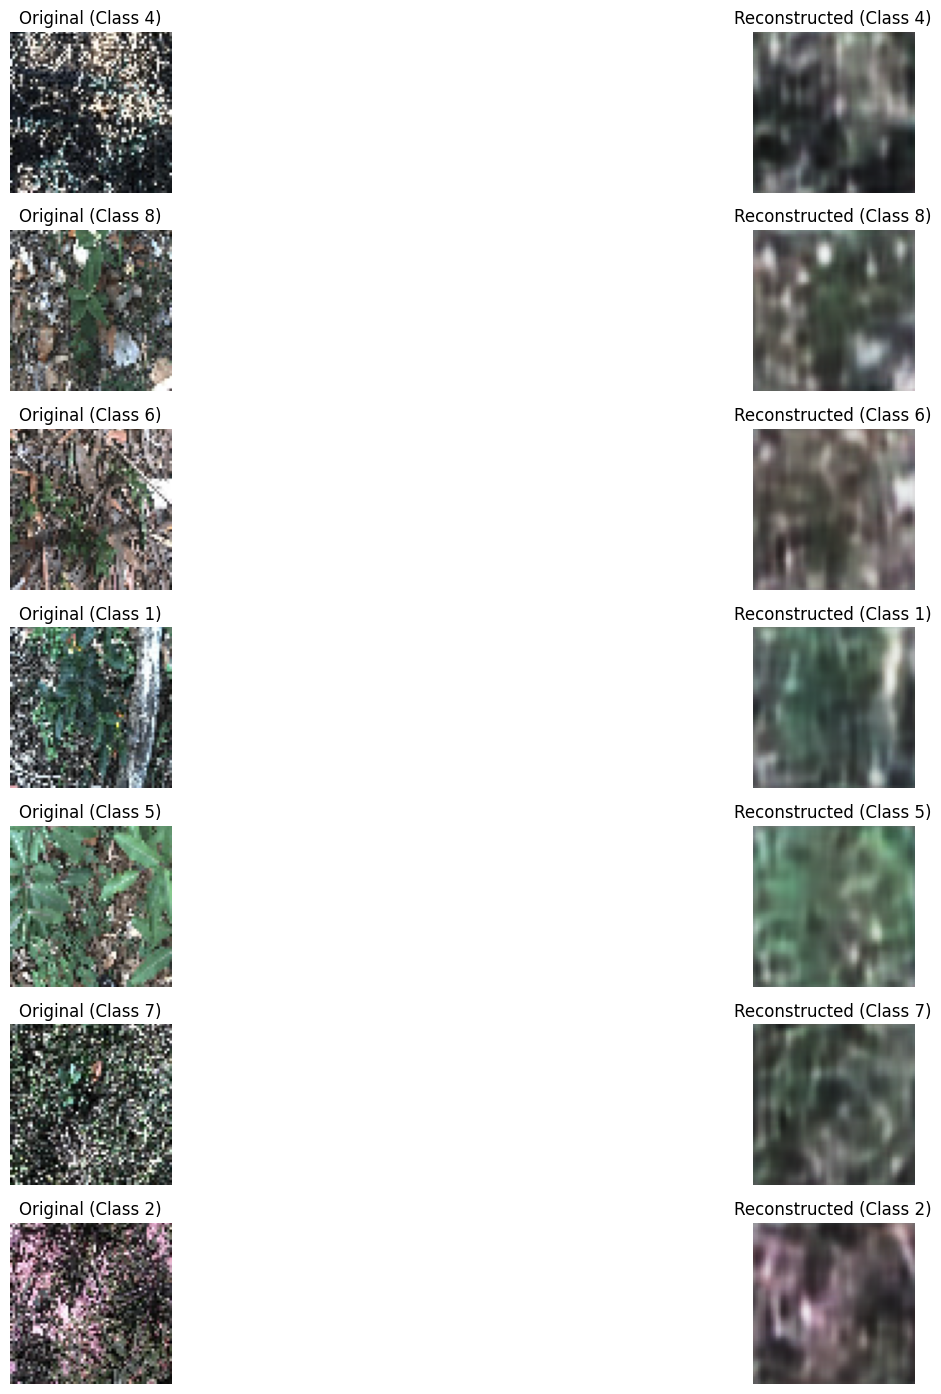

In [10]:
# Visualize reconstructed images
import matplotlib.pyplot as plt

def visualize_reconstruction_by_class(model, images, labels, n):
    plt.figure(figsize=(15, n * 2))
    
    # Keep track of displayed classes
    displayed_classes = set()

    for i in range(n):
        class_label = labels[i]
        if class_label not in displayed_classes:
            displayed_classes.add(class_label)

            # Original image
            plt.subplot(n, 2, len(displayed_classes) * 2 - 1)
            plt.imshow(images[i])
            plt.axis('off')
            plt.title(f"Original (Class {class_label})")
            
            # Reconstructed image
            reconstructed = model.predict(images[i][np.newaxis, ...])[0]
            plt.subplot(n, 2, len(displayed_classes) * 2)
            plt.imshow(reconstructed)
            plt.axis('off')
            plt.title(f"Reconstructed (Class {class_label})")

    plt.tight_layout()
    plt.show()

# Visualize reconstructions for all classes
visualize_reconstruction_by_class(autoencoder, X_val, y_val, n = 10)

## 3. Using the pre-trained AutoEncoder to train Linear Models (kNN, Random Forest, and SVM)

##### Replace the images with the reconstructed images obtained by the pre-trained autoencoder. 

In [11]:
X_train_final = autoencoder.predict(X_train)
X_test_final = autoencoder.predict(X_val)

y_train_final = y_train
y_test_final = y_val 

225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


In [12]:
print(X_train_final.shape)
print(X_test_final.shape)

print(y_train_final.shape)
print(y_test_final.shape)

(7200, 64, 64, 3)
(1800, 64, 64, 3)
(7200,)
(1800,)


In [13]:
from sklearn.preprocessing import LabelEncoder

# Convert labels to discrete values if necessary
label_encoder = LabelEncoder()
y_train_final = label_encoder.fit_transform(y_train_final)
y_test_final = label_encoder.transform(y_test_final)

# Flattening
X_train_final = X_train_final.reshape(X_train_final.shape[0], -1)  # Flattening each image
X_test_final = X_test_final.reshape(X_test_final.shape[0], -1)  # Flattening each image

### kNN using AutoEncoder 

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 27, 30]

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_final, y_train_final)
    y_pred_knn = knn.predict(X_test_final)
    f1_knn = f1_score(y_test_final, y_pred_knn, average='macro')
    print(f'kNN F1 Score with k={k}: {f1_knn:.4f}')

kNN F1 Score with k=1: 0.1925
kNN F1 Score with k=3: 0.1865
kNN F1 Score with k=5: 0.1740
kNN F1 Score with k=7: 0.1774
kNN F1 Score with k=9: 0.1836
kNN F1 Score with k=11: 0.1821
kNN F1 Score with k=13: 0.1766
kNN F1 Score with k=15: 0.1768
kNN F1 Score with k=17: 0.1783
kNN F1 Score with k=19: 0.1705
kNN F1 Score with k=21: 0.1744
kNN F1 Score with k=24: 0.1700
kNN F1 Score with k=27: 0.1693
kNN F1 Score with k=30: 0.1651


In [15]:
# Make kNN predictions with k=9
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
knn_model = knn.fit(X_train_final, y_train_final)
y_pred_knn = knn_model.predict(X_test_final)

#### kNN - Classification Report

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report

# Evaluate using macro-averaged precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_final, y_pred_knn, average='macro')

# Define the label mapping
target_names = ['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']

# Output the evaluation metrics
print(f"Macro-averaged Precision: {precision:.2f}")
print(f"Macro-averaged Recall: {recall:.2f}")
print(f"Macro-averaged F1 score: {f1:.2f}")

# Classification Report
print("Classification Report for kNN:")
print(classification_report(y_test_final,y_pred_knn,target_names=target_names))

Macro-averaged Precision: 0.24
Macro-averaged Recall: 0.21
Macro-averaged F1 score: 0.19
Classification Report for kNN:
                precision    recall  f1-score   support

 Chinese Apple       0.19      0.13      0.15       200
       Lantana       0.42      0.12      0.19       200
   Parkinsonia       0.21      0.49      0.29       200
    Parthenium       0.20      0.10      0.13       200
Prickly acacia       0.12      0.12      0.12       200
   Rubber vine       0.31      0.03      0.05       200
     Siam weed       0.34      0.36      0.35       200
    Snake Weed       0.20      0.23      0.22       200
     Negatives       0.17      0.32      0.22       200

      accuracy                           0.21      1800
     macro avg       0.24      0.21      0.19      1800
  weighted avg       0.24      0.21      0.19      1800



#### kNN - Confusion Matrix

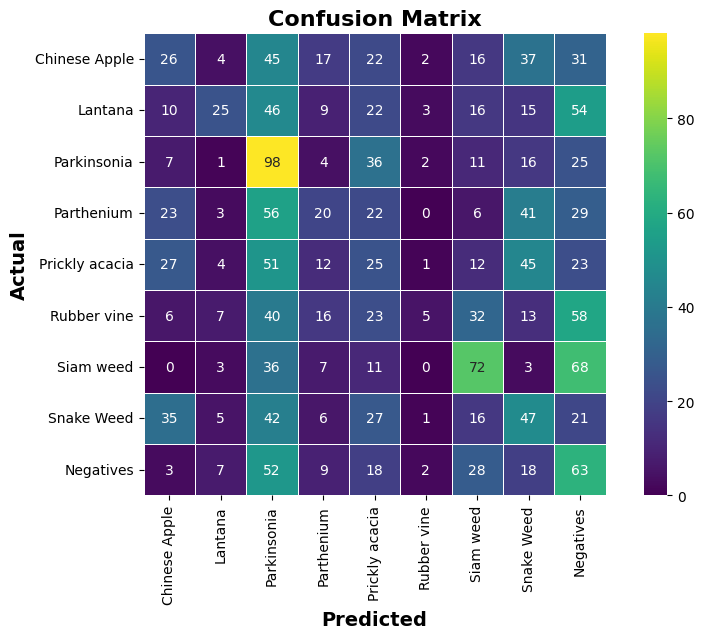

In [17]:
# Generate and print the confusion matrix
from sklearn.metrics import confusion_matrix 
import seaborn as sns

conf_matrix = confusion_matrix(y_test_final, y_pred_knn)

plt.figure(figsize=(10, 6))

sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives'],
    yticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()

### Random Forest using AutoEncoder

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,10,50],
             'n_estimators':[1,10,100]}

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

clf = GridSearchCV(rf, parameters)
clf.fit(X_train_final, y_train_final)
clf.best_estimator_

RandomForestClassifier(max_depth=50, random_state=42)

In [20]:
results_df = pd.DataFrame(clf.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
50_100,"{'max_depth': 50, 'n_estimators': 100}",1,0.313194,0.005909
10_100,"{'max_depth': 10, 'n_estimators': 100}",2,0.308750,0.006328
10_10,"{'max_depth': 10, 'n_estimators': 10}",3,0.239583,0.010310
50_10,"{'max_depth': 50, 'n_estimators': 10}",4,0.224306,0.005325
2_100,"{'max_depth': 2, 'n_estimators': 100}",5,0.218056,0.014075
2_10,"{'max_depth': 2, 'n_estimators': 10}",6,0.211667,0.007485
10_1,"{'max_depth': 10, 'n_estimators': 1}",7,0.179028,0.010992
50_1,"{'max_depth': 50, 'n_estimators': 1}",8,0.165972,0.010006
2_1,"{'max_depth': 2, 'n_estimators': 1}",9,0.153333,0.010735


#### Random Forest - Classification Report

In [21]:
# make random forest prediction
rf_model = RandomForestClassifier(max_depth=50, n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train_final)
y_pred_rf = rf_model.predict(X_test_final)

# Evaluate using macro-averaged precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_final, y_pred_rf, average='macro')

# Define the label mapping
target_names = ['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']

# Output the evaluation metrics
print(f"Macro-averaged Precision: {precision:.2f}")
print(f"Macro-averaged Recall: {recall:.2f}")
print(f"Macro-averaged F1 score: {f1:.2f}")

# Classification Report
print("Classification Report for Random Forest:")
print(classification_report(y_test_final, y_pred_rf, target_names=target_names))

Macro-averaged Precision: 0.30
Macro-averaged Recall: 0.30
Macro-averaged F1 score: 0.29
Classification Report for Random Forest:
                precision    recall  f1-score   support

 Chinese Apple       0.29      0.30      0.29       200
       Lantana       0.30      0.30      0.30       200
   Parkinsonia       0.35      0.49      0.41       200
    Parthenium       0.24      0.22      0.23       200
Prickly acacia       0.22      0.21      0.21       200
   Rubber vine       0.28      0.14      0.19       200
     Siam weed       0.37      0.57      0.45       200
    Snake Weed       0.28      0.25      0.27       200
     Negatives       0.35      0.25      0.29       200

      accuracy                           0.30      1800
     macro avg       0.30      0.30      0.29      1800
  weighted avg       0.30      0.30      0.29      1800



#### Random Forest - Confusion Matrix

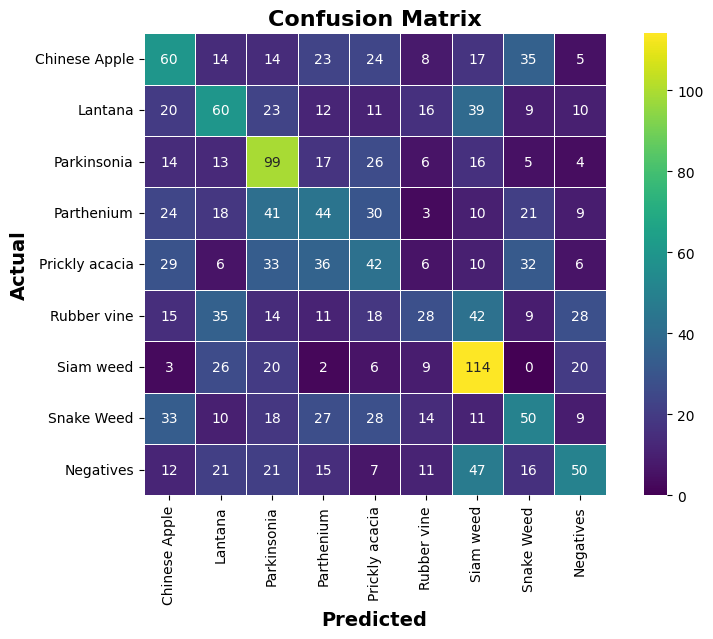

In [22]:
# Generate and print the confusion matrix
from sklearn.metrics import confusion_matrix 
conf_matrix = confusion_matrix(y_test_final, y_pred_rf)

plt.figure(figsize=(10, 6))

sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives'],
    yticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()

### SVM using AutoEncoder

In [ ]:
from sklearn import svm
from sklearn.metrics import f1_score

param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': [1, 0.1, 0.01]  # Kernel coefficient
}

# Store results
best_f1 = 0
best_params = {}

# Iterate over the parameter grid
for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        # Train the SVM model with the current parameters
        svc = svm.SVC(kernel='rbf', C=C, gamma=gamma)
        svc.fit(X_train_final, y_train_final)
        
        # Predict on the test set
        y_pred_svm = svc.predict(X_test_final)
        
        # Calculate the F1 score with appropriate averaging for multiclass
        f1 = f1_score(y_test_final, y_pred_svm, average='macro')  # Change average as needed
        print(f"Parameters: C={C}, gamma={gamma}, F1 score={f1:.4f}")
        
        # Update the best model if current F1 score is better
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'C': C, 'gamma': gamma}

# Output the best parameters and corresponding F1 score
print("\nBest Parameters:", best_params)
print("Best F1 Score:", best_f1)


Parameters: C=0.1, gamma=1, F1 score=0.0955
Parameters: C=0.1, gamma=0.1, F1 score=0.0519
Parameters: C=0.1, gamma=0.01, F1 score=0.2480


#### SVM - Classification Report

In [ ]:
# Make svm prediction
svc_rbf = svm.SVC(kernel='rbf', gamma="scale") # best값으로 바꾸기 
svc_rbf.fit(X_train_final, y_train_final)
y_pred_svm = svc_rbf.predict(X_test_final)

# Evaluate using macro-averaged precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_final, y_pred_svm, average='macro')

# Define the label mapping
target_names = ['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']

# Output the evaluation metrics
print(f"Macro-averaged Precision: {precision:.2f}")
print(f"Macro-averaged Recall: {recall:.2f}")
print(f"Macro-averaged F1 score: {f1:.2f}")

# Classification Report
print("Classification Report for SVM:")
print(classification_report(y_test_final,y_pred_svm,target_names=target_names))

training accuracy: 0.739722
testing accuracy: 0.369444
              precision    recall  f1-score   support

           0       0.28      0.30      0.29       200
           1       0.41      0.37      0.39       200
           2       0.41      0.54      0.47       200
           3       0.34      0.28      0.31       200
           4       0.34      0.35      0.35       200
           5       0.39      0.29      0.33       200
           6       0.45      0.56      0.50       200
           7       0.36      0.30      0.33       200
           8       0.32      0.34      0.33       200

    accuracy                           0.37      1800
   macro avg       0.37      0.37      0.37      1800
weighted avg       0.37      0.37      0.37      1800



#### SVM Model Confusion Matrix

In [ ]:
# Generate and print the confusion matrix
from sklearn.metrics import confusion_matrix 
conf_matrix = confusion_matrix(y_test_final, y_pred3)

plt.figure(figsize=(10, 6))

sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives'],
    yticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()